### 数据处理及建模思路
1. 将训练和测试集合并为一个大表
2. 找出其中离群点, 包括 0 点
3. 去掉离群点, 得到一个小表
4. 将离群点去掉 0 点后使用上下均值代替, 得到一张大表
5. 使用大表训练 1 个模型, 预测全部结果
6. 使用小表训练 1 个模型, 预测部分结果
7. 将大表中的小表部分的预测结果进行替换
8. 将大表中的零值结果进行替换
9. 分别使用 lightgbm/xgboost/gbrt/randomforest 进行预测并融合

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
import scipy as sp

In [3]:
!ls ../raw

clean_data.csv     public.train.csv   test_data.csv
public.test.csv    submit_example.csv train_data.csv


In [4]:
df_train = pd.read_csv('../raw/public.train.csv')
df_test = pd.read_csv('../raw/public.test.csv')

In [5]:
all_data = pd.concat([df_train, df_test], axis=0).sort_values(by='ID').reset_index().drop(['index'], axis=1)

In [5]:
clean_data = all_data.copy()
clean_data.shape

(17409, 21)

## 零点

In [6]:
zero_index = clean_data[clean_data.平均功率 == 0].index
zero_index

Int64Index([    0,   171,   343,   512,   684,   855,  1024,  1195,  1365,
             1366,
            ...
            15882, 16074, 16281, 16459, 16667, 16876, 17061, 17075, 17277,
            17408],
           dtype='int64', length=114)

In [7]:
clean_data.drop(zero_index, inplace=True)
clean_data.shape

(17295, 21)

## 板温

In [8]:
def plot_points(feature):
    fig, ax = plt.subplots()
    ax.scatter(x = clean_data[feature], y = clean_data['发电量'])
    plt.ylabel('发电量', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show()

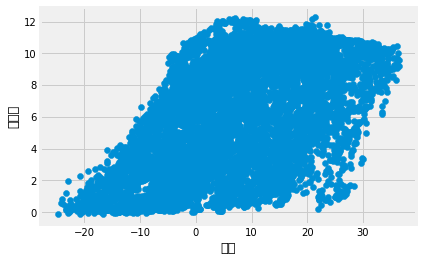

In [9]:
plot_points('板温')

In [10]:
clean_data.板温.describe()

count    17295.000000
mean         6.767316
std         11.763827
min        -24.790000
25%         -1.890000
50%          5.680000
75%         15.640000
max         36.800000
Name: 板温, dtype: float64

板温分布正常, 未看到离群点

## 现场温度

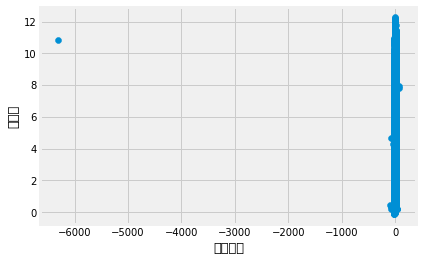

In [11]:
plot_points('现场温度')

根据图形来看, <-30° 和 > 50° 是离群点, 需要去掉和替换

In [12]:
clean_data.现场温度.describe()

count    17295.00000
mean        -0.58706
std         69.26917
min      -6414.20000
25%         -7.60000
50%         -2.40000
75%          8.30000
max         78.70000
Name: 现场温度, dtype: float64

In [13]:
outlier_index = clean_data[(clean_data.现场温度 < -30) | (clean_data.现场温度 > 50)].index
outlier_index

Int64Index([  127,   468,   499,   531,   673,  1178,  1561,  2214,  2887,
             3108,  3136,  3253,  3254,  3429,  6976, 11366],
           dtype='int64')

In [14]:
# 暂时去掉
clean_data.drop(clean_data[(clean_data.现场温度 < -30) | (clean_data.现场温度 > 50)].index, inplace=True)

In [15]:
clean_data.shape

(17279, 21)

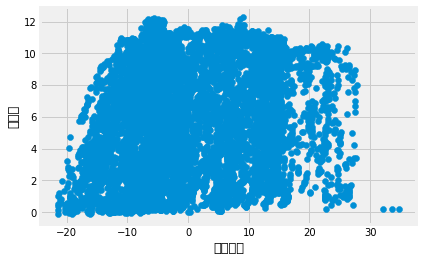

In [16]:
plot_points('现场温度')

## 转换效率A

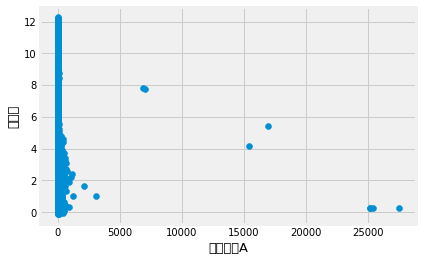

In [17]:
plot_points('转换效率A')

In [18]:
clean_data.转换效率A.describe()

count     17279.000000
mean         57.494837
std        1477.239967
min           0.000000
25%          20.520000
50%          24.980000
75%          36.405000
max      183289.380000
Name: 转换效率A, dtype: float64

In [19]:
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.转换效率A > 150].index))

In [20]:
clean_data.drop(clean_data[clean_data.转换效率A > 150].index, inplace=True)

In [21]:
clean_data.shape

(16969, 21)

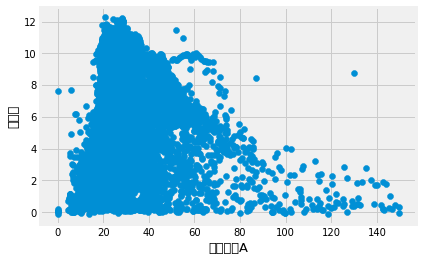

In [22]:
plot_points('转换效率A')

## 转换效率 B

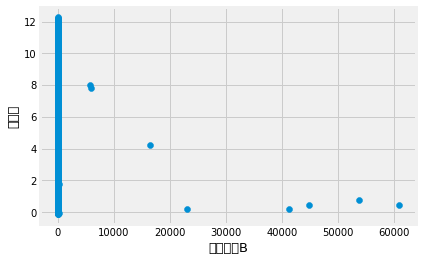

In [23]:
plot_points('转换效率B')

In [24]:
clean_data.转换效率B.describe()

count    16969.000000
mean        57.049397
std       1032.884483
min          0.000000
25%         20.260000
50%         24.710000
75%         35.840000
max      60969.930000
Name: 转换效率B, dtype: float64

In [25]:
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.转换效率B > 150].index))
outlier_index

Int64Index([ 127,  468,  499,  531,  673, 1178, 1561, 2214, 2887, 3108,
            ...
            3318, 3610, 3611, 4460, 4864, 5083, 5261, 5459, 5565, 7280],
           dtype='int64', length=359)

In [26]:
clean_data.drop(clean_data[clean_data.转换效率B > 150].index, inplace=True)

In [27]:
clean_data.shape

(16936, 21)

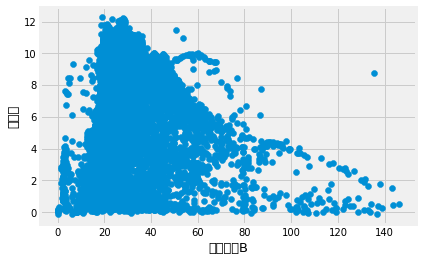

In [28]:
plot_points('转换效率B')

## 转换效率 C

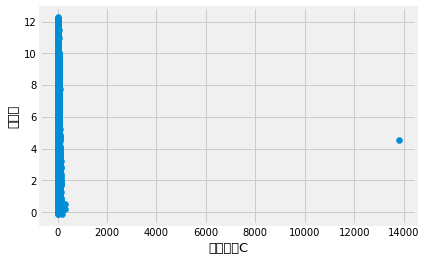

In [29]:
plot_points('转换效率C')

In [30]:
clean_data.转换效率C.describe()

count    16936.000000
mean        31.354265
std        107.281686
min          0.000000
25%         20.580000
50%         25.190000
75%         35.990000
max      13816.930000
Name: 转换效率C, dtype: float64

In [31]:
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.转换效率C > 150].index))
outlier_index

Int64Index([ 127,  468,  499,  531,  673, 1178, 1561, 2214, 2887, 3108,
            ...
            2237, 2415, 2416, 2585, 3778, 4461, 4630, 4872, 5876, 5880],
           dtype='int64', length=387)

In [32]:
clean_data.drop(clean_data[clean_data.转换效率C > 150].index, inplace=True)
clean_data.shape

(16908, 21)

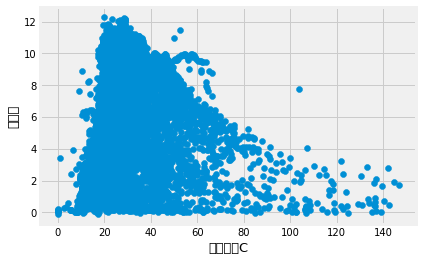

In [33]:
plot_points('转换效率C')

## 电压A

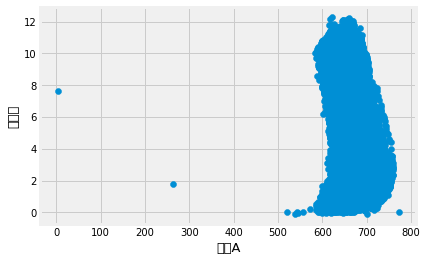

In [34]:
plot_points('电压A')

In [35]:
clean_data['电压A'].describe()

count    16908.00000
mean       666.00621
std         33.77270
min          3.00000
25%        641.00000
50%        668.00000
75%        689.00000
max        773.00000
Name: 电压A, dtype: float64

In [36]:
# 电压 < 500 的拿掉
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.电压A < 500].index))
outlier_index

Int64Index([ 127,  468,  499,  531,  673, 1178, 1561, 2214, 2887, 3108,
            ...
            2585, 3778, 4461, 4630, 4872, 5876, 5880,  174,  498, 2890],
           dtype='int64', length=390)

In [37]:
clean_data.drop(clean_data[clean_data.电压A < 500].index, inplace=True)
clean_data.shape

(16905, 21)

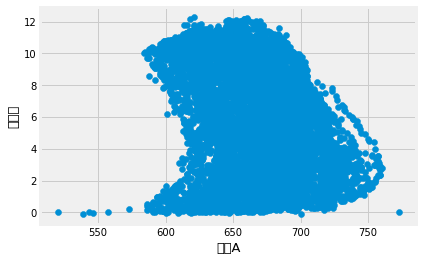

In [38]:
plot_points('电压A')

## 电压 B

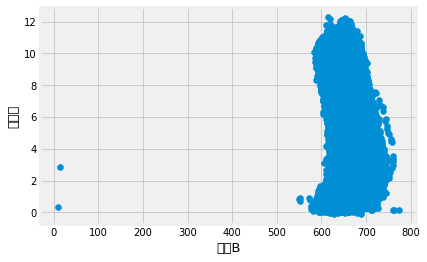

In [39]:
plot_points('电压B')

In [40]:
clean_data['电压B'].describe()

count    16905.000000
mean       662.904052
std         35.012938
min          9.000000
25%        639.000000
50%        665.000000
75%        686.000000
max        774.000000
Name: 电压B, dtype: float64

In [41]:
# 电压 < 500 的拿掉
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.电压B < 500].index))
outlier_index

Int64Index([  127,   468,   499,   531,   673,  1178,  1561,  2214,  2887,
             3108,
            ...
             5880,   174,   498,  2890,  1066,  4068,  5488, 14216, 15833,
            15971],
           dtype='int64', length=396)

In [42]:
clean_data.drop(clean_data[clean_data.电压B < 500].index, inplace=True)
clean_data.shape

(16899, 21)

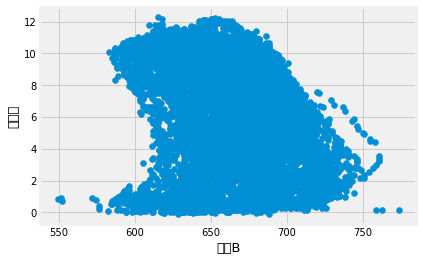

In [43]:
plot_points('电压B')

## 电压 C

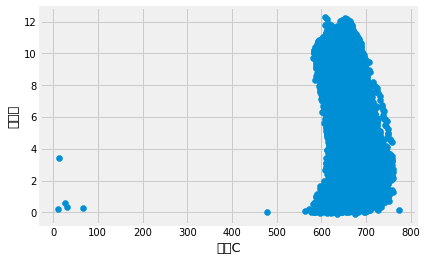

In [44]:
plot_points('电压C')

In [45]:
clean_data['电压C'].describe()

count    16899.000000
mean       662.925972
std         36.990388
min         10.000000
25%        638.000000
50%        665.000000
75%        686.000000
max        777.000000
Name: 电压C, dtype: float64

In [46]:
# 电压 < 500 的拿掉
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.电压C < 500].index))
outlier_index

Int64Index([  127,   468,   499,   531,   673,  1178,  1561,  2214,  2887,
             3108,
            ...
             3304,  3310,  3312,  3967,  4301,  4857, 10456, 10457, 12348,
            12723],
           dtype='int64', length=406)

In [47]:
clean_data.drop(clean_data[clean_data.电压C < 500].index, inplace=True)
clean_data.shape

(16889, 21)

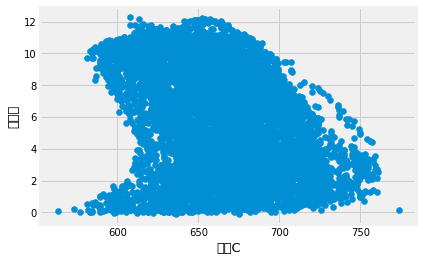

In [48]:
plot_points('电压C')

## 电流 A

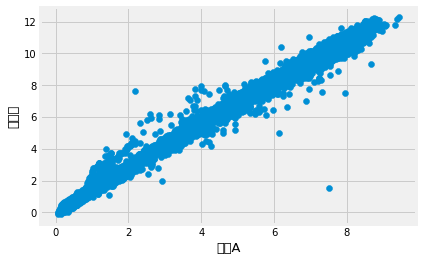

In [49]:
plot_points('电流A')

## 电流 B

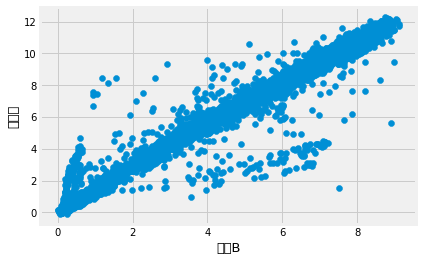

In [50]:
plot_points('电流B')

## 电流 C

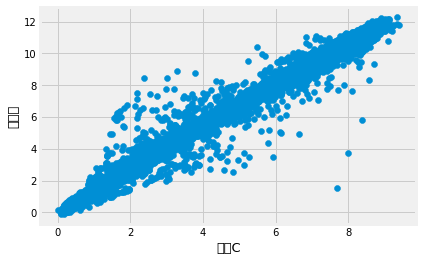

In [51]:
plot_points('电流C')

## 功率

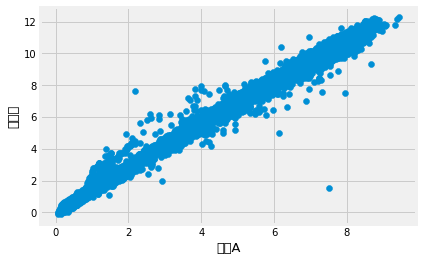

In [52]:
plot_points('电流A')

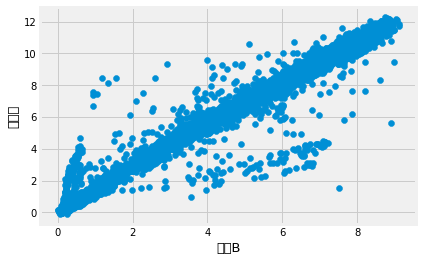

In [53]:
plot_points('电流B')

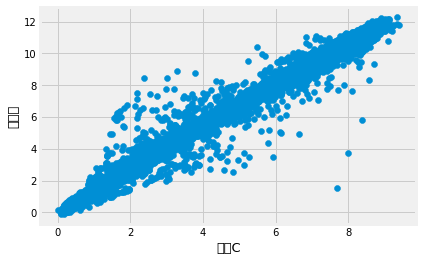

In [54]:
plot_points('电流C')

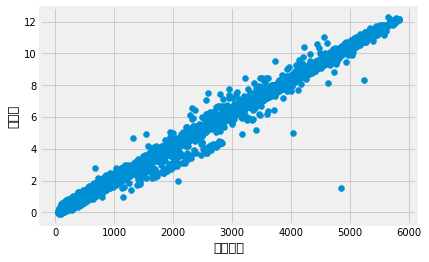

In [55]:
plot_points('平均功率')

## 风速

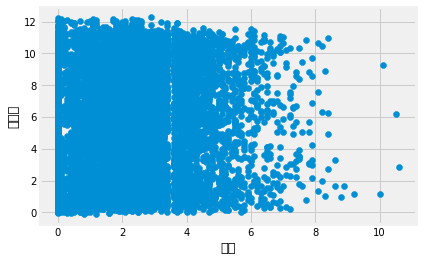

In [56]:
plot_points('风速')

## 风向

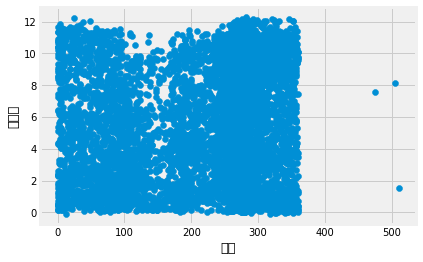

In [57]:
plot_points('风向')

In [58]:
# 去掉风向 > 360°
outlier_index = pd.Int64Index(list(outlier_index) + list(clean_data[clean_data.风向 > 360].index))
outlier_index

Int64Index([  127,   468,   499,   531,   673,  1178,  1561,  2214,  2887,
             3108,
            ...
             3967,  4301,  4857, 10456, 10457, 12348, 12723,  4891,  6348,
            15924],
           dtype='int64', length=409)

In [59]:
clean_data.drop(clean_data[clean_data.风向 > 360].index, inplace=True)
clean_data.shape

(16886, 21)

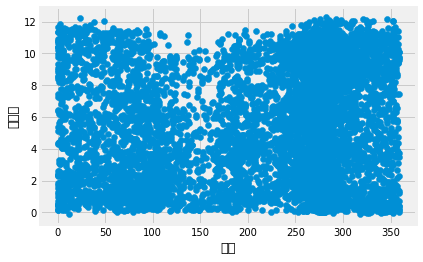

In [61]:
plot_points('风向')

In [60]:
clean_data.to_csv('../raw/clean_data.csv',index=False)  

## 拆分数据

In [8]:
clean_data = pd.read_csv('../raw/clean_data.csv')

In [10]:
train_data = clean_data[clean_data['发电量'] > -1].sort_values(by='ID', ascending=True)

In [11]:
test_index = clean_data.index[np.where(np.isnan(clean_data))[0]]

In [12]:
test_data = clean_data.loc[test_index].sort_values(by='ID', ascending=True)

In [13]:
# 去重
train_data.drop_duplicates(train_data.columns.drop('ID'), keep='first', inplace=True)
len(train_data)

8702

In [14]:
# 全部数据集 X, y
def generate_train_data(train_data, test_data, poly=False, select=False):

    y = train_data['发电量']
    X = train_data.drop(['发电量','ID'], axis=1)
    sub_data = test_data.drop(['发电量', 'ID'], axis=1)

    if poly:
        from sklearn.preprocessing import PolynomialFeatures
        poly = PolynomialFeatures(degree=2, interaction_only=True)
        X = poly.fit_transform(X)
        sub_data = poly.transform(sub_data)
        
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if select:
        from sklearn.feature_selection import SelectFromModel
        sm = SelectFromModel(GradientBoostingRegressor(random_state=2))
        X = sm.fit_transform(X, y)
#         X_test = sm.transform(X_test)
        sub_data = sm.transform(sub_data)
        
    return X, y, sub_data

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sklearn.utils import shuffle

In [16]:
X, y, sub_data = generate_train_data(train_data, test_data, poly=True, select=True)
print(X.shape, sub_data.shape)

(8702, 52) (8169, 52)


## lightgbm

In [150]:
import lightgbm as lgb

In [151]:
lgb_train = lgb.Dataset(X, y)
# lgb_test = lgb.Dataset(X_test, y_test)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.5,
'num_leaves': 90,
'min_data': 55,
'min_hessian': 1,
'verbose': -1,}

gbm = lgb.train(params, lgb_train, 4000)
# pred = gbm.predict(X_test)
# rmsetmp = sp.sqrt(sp.mean((y_test - pred) ** 2))
# score = 1 / (1 + rmsetmp)

# print('This time score is: '+ str(score))

In [153]:
prediction = gbm.predict(sub_data)

In [154]:
light_gbm = pd.read_csv('./results/result_20180805a_lightgbm-alldata.csv', names=['ID', '发电量'])

In [155]:
light_gbm.head()

,ID,发电量
0,1,0.379993
1,9,1.313329
2,13,2.152056
3,17,3.389661
4,18,3.625742


In [156]:
prediction.shape

(8169,)

In [157]:
test_data['发电量'] = prediction

In [158]:
test_clean = test_data[['ID', '发电量']]

In [159]:
test_clean.head()

,ID,发电量
5,13,2.171163
9,17,3.381499
10,18,3.611689
13,21,4.139737
15,23,4.291921


In [160]:
data_merge = pd.merge(light_gbm, test_clean, how='left', on='ID')

In [161]:
data_merge.head()

,ID,发电量_x,发电量_y
0,1,0.379993,NaN
1,9,1.313329,NaN
2,13,2.152056,2.171163
3,17,3.389661,3.381499
4,18,3.625742,3.611689


In [162]:
data_merge[data_merge['发电量_y'] > -1].index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408],
           dtype='int64', length=8169)

In [163]:
data_merge.loc[small_index, '发电量_x'] = prediction

In [164]:
data_merge[['ID', '发电量_x']].to_csv('./results/result_20180807b_lightgbm-twomodels.csv',index=False, header=False)  

## gbrt

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
est = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1,
         max_depth=6, random_state=0, loss='ls').fit(X, y)

In [19]:
prediction2 = est.predict(sub_data)

In [20]:
gbrt = pd.read_csv('./results/result_20180805a_GBRT_alldata.csv', names=['ID', '发电量'])

In [21]:
gbrt

,ID,发电量
0,1,0.379993
1,9,1.261699
2,13,2.103544
3,17,3.372330
4,18,3.627773
5,21,4.150509
6,23,4.233892
7,25,4.853679
8,26,4.962057
9,28,5.259857


In [22]:
test_data['发电量'] = prediction2

In [23]:
test_clean = test_data[['ID', '发电量']]

In [24]:
data_merge = pd.merge(gbrt, test_clean, how='left', on='ID')

In [25]:
data_merge.head()

,ID,发电量_x,发电量_y
0,1,0.379993,NaN
1,9,1.261699,NaN
2,13,2.103544,2.136382
3,17,3.372330,3.355426
4,18,3.627773,3.644275


In [27]:
small_index = data_merge[data_merge['发电量_y'] > -1].index

In [28]:
data_merge.loc[small_index, '发电量_x'] = prediction2

In [29]:
data_merge[['ID', '发电量_x']].to_csv('./results/result_20180808a_gbrt-twomodels.csv',index=False, header=False)  